# Lending Club Final Model

By: Kevin Kuc

## Step 1: Import packages

In [1]:
import pandas as pd
import numpy as np
import random2
import copy

# exploratory analysis
import matplotlib.pyplot as plt
import mlxtend
from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap
import seaborn as sns
from IPython.display import Image
from matplotlib.ticker import PercentFormatter

# model fit
import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf

# For producing decision tree diagrams.
from IPython.display import Image


# These commands below set some options for pandas and to have matplotlib show the charts in the notebook
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format
pd.options.mode.chained_assignment = None  # default='warn'

random2.seed(0)
np.random.seed(0)
torch.manual_seed(0)

## Step 2: Read data

In [2]:
# Training
train_df = pd.read_csv('../data/train_data.csv')
test_df = pd.read_csv('../data/test_data.csv')
validation_df = pd.read_csv('../data/val_data.csv')

train_df_deep = copy.deepcopy(train_df)
test_df_deep = copy.deepcopy(test_df)
validation_df_deep = copy.deepcopy(validation_df)

# Drop nan values
train_df_deep.dropna(axis=0, inplace=True)
test_df_deep.dropna(axis=0, inplace=True)
validation_df_deep.dropna(axis=0, inplace=True)

In [3]:
#Find Shape
print("Shape of training:", train_df_deep.shape)
print("Shape of test:", test_df_deep.shape)
print("Shape of validation:", validation_df_deep.shape)

Shape of training: (191993, 34)
Shape of test: (59998, 34)
Shape of validation: (47999, 34)


## Feature Selection
### full_features, partial_features, selected_features

In [4]:
features_target = train_df_deep.columns
full_features = features_target.drop(['loan_status'])
partial_features = full_features.drop(['recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt',
       'collections_12_mths_ex_med', 'application_type', 'acc_now_delinq',
       'chargeoff_within_12_mths', 'tax_liens', 'disbursement_method',
       'debt_settlement_flag'])
partial_features

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'installment', 'sub_grade', 'home_ownership', 'annual_inc',
       'verification_status', 'purpose', 'addr_state', 'delinq_2yrs',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc',
       'initial_list_status', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee'],
      dtype='object')

In [5]:
X_train_shape = train_df_deep[full_features].astype(float).values.shape
y_train_shape = train_df_deep['loan_status'].astype(float).values.shape

X_val_shape = validation_df_deep[full_features].astype(float).values.shape
y_val_shape = validation_df_deep['loan_status'].astype(float).values.shape

X_test_shape = test_df_deep[full_features].astype(float).values.shape
y_test_shape = test_df_deep['loan_status'].astype(float).values.shape

In [6]:
print(f'X_train = {X_train_shape}, Y_train = {y_train_shape}')
print(f'X_val = {X_val_shape}, Y_val = {y_val_shape}')
print(f'X_val = {X_test_shape}, Y_val = {y_test_shape}')

X_train = (191993, 33), Y_train = (191993,)
X_val = (47999, 33), Y_val = (47999,)
X_val = (59998, 33), Y_val = (59998,)


## Step 3: Model Build

All features

In [7]:
class CustomModel(nn.Module):
    def __init__(self, input_size, hidden_layer_sizes, activation='relu'):
        super(CustomModel, self).__init__()
        layers = []
        layers.append(nn.Flatten())  # Flatten layer

        if hidden_layer_sizes:
            for layer_size in hidden_layer_sizes:
                layers.append(nn.Linear(input_size, layer_size))
                if activation == 'relu':
                    layers.append(nn.ReLU())
                elif activation == 'sigmoid':
                    layers.append(nn.Sigmoid())
                input_size = layer_size

        layers.append(nn.Linear(input_size, 1))  # Final layer
        layers.append(nn.Sigmoid())  # Sigmoid activation for binary classification

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)
    
def train_and_evaluate_nn(features,
                           hidden_layer_sizes=[],
                           activation='relu',
                           optimizer='Adam',
                           learning_rate=0.01,
                           num_epochs=5,
                           batch_size=128):

    # Build the model
    model = CustomModel(input_size=len(features), hidden_layer_sizes=hidden_layer_sizes, activation=activation)

    # Define loss function and optimizer
    criterion = nn.BCELoss()
    if optimizer == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # Convert data to PyTorch tensors
    X_train = torch.tensor(train_df_deep[features].astype(np.float32).values)
    y_train = torch.tensor(train_df_deep['loan_status'].astype(np.float32).values).view(-1, 1)

    X_val = torch.tensor(validation_df_deep[features].astype(np.float32).values)
    y_val = torch.tensor(validation_df_deep['loan_status'].astype(np.float32).values).view(-1, 1)

    # Training loop
    train_losses = []
    val_losses = []
    train_accuracy = []
    val_accuracy = []
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # Calculate training accuracy
        preds_train = torch.round(outputs)
        correct_train = (preds_train == y_train).sum().item()
        accuracy_train = correct_train / len(y_train)
        train_accuracy.append(accuracy_train)

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
            val_losses.append(val_loss.item())

            # Calculate validation accuracy
            preds_val = torch.round(val_outputs)
            correct_val = (preds_val == y_val).sum().item()
            accuracy_val = correct_val / len(y_val)
            val_accuracy.append(accuracy_val)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Train Accuracy: {accuracy_train}, Val Accuracy: {accuracy_val}")

    # Plot losses
    plt.plot(train_losses, label='Train Loss', color='#003262')
    plt.plot(val_losses, label='Validation Loss', color='#FDB515')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot accuracies
    plt.plot(train_accuracy, label='Train Accuracy', color='#003262')
    plt.plot(val_accuracy, label='Validation Accuracy', color='#FDB515')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    return model


Epoch 1/30, Train Loss: 50.03179931640625, Val Loss: 49.4622802734375, Train Accuracy: 0.4996744672982869, Val Accuracy: 0.5051771911914832
Epoch 2/30, Train Loss: 49.61982345581055, Val Loss: 45.764610290527344, Train Accuracy: 0.5036381534743454, Val Accuracy: 0.5414487801829205
Epoch 3/30, Train Loss: 46.01359939575195, Val Loss: 41.5664176940918, Train Accuracy: 0.5389154812935888, Val Accuracy: 0.5822412966936811
Epoch 4/30, Train Loss: 41.773773193359375, Val Loss: 39.04911422729492, Train Accuracy: 0.5798284312448891, Val Accuracy: 0.6059292901935457
Epoch 5/30, Train Loss: 39.483314514160156, Val Loss: 38.05961227416992, Train Accuracy: 0.6014802623012298, Val Accuracy: 0.6158461634617388
Epoch 6/30, Train Loss: 38.42262268066406, Val Loss: 37.59210205078125, Train Accuracy: 0.6123400332303782, Val Accuracy: 0.6212212754432384
Epoch 7/30, Train Loss: 37.87889099121094, Val Loss: 37.522037506103516, Train Accuracy: 0.6183871286974004, Val Accuracy: 0.6225338027875581
Epoch 8/30,

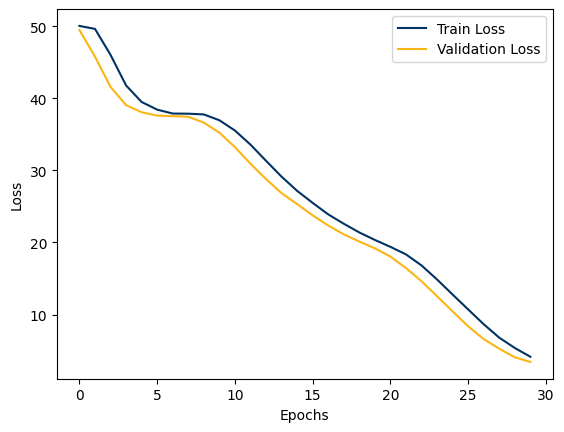

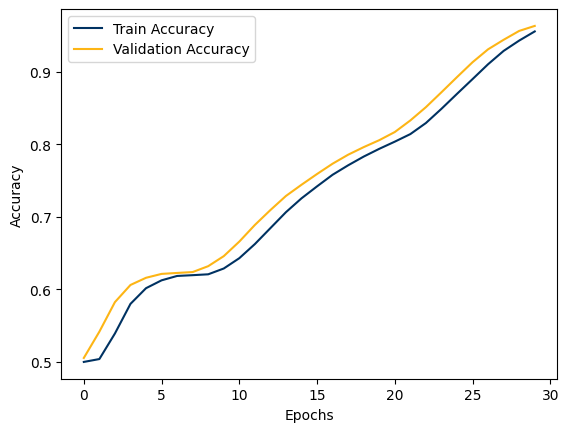

Validation Accuracy with relu & Adam: CustomModel(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=33, out_features=1, bias=True)
    (2): Sigmoid()
  )
)


In [8]:
model_full_features = train_and_evaluate_nn(full_features,
                       hidden_layer_sizes=[],
                       activation='relu',
                       optimizer='Adam',
                       learning_rate=0.01,
                       num_epochs=30)
print('Validation Accuracy with relu & Adam:', model_full_features)


In [9]:
def evaluate_model(model, features, target):
    # Convert data to PyTorch tensors
    X_test = torch.tensor(features.astype(np.float32).values)
    y_test = torch.tensor(target.astype(np.float32).values).view(-1, 1)

    # Make predictions using the trained model
    with torch.no_grad():
        predictions = model(X_test)
        binary_predictions = torch.round(predictions)

    # Calculate accuracy
    accuracy = torch.mean((binary_predictions == y_test).to(torch.float)).item()

    # Calculate number of correct predictions
    num_correct = torch.sum(binary_predictions == y_test).item()

    # Calculate number of incorrect predictions
    num_incorrect = len(y_test) - num_correct

    print("Accuracy:", accuracy)
    print("Number of correct predictions:", num_correct)
    print("Number of incorrect predictions:", num_incorrect)

    return num_correct,num_incorrect

# Assuming `model_full_features` is your trained PyTorch model
evaluated = evaluate_model(model_full_features, test_df_deep[full_features], test_df_deep['loan_status'])


Accuracy: 0.9616987109184265
Number of correct predictions: 57700
Number of incorrect predictions: 2298


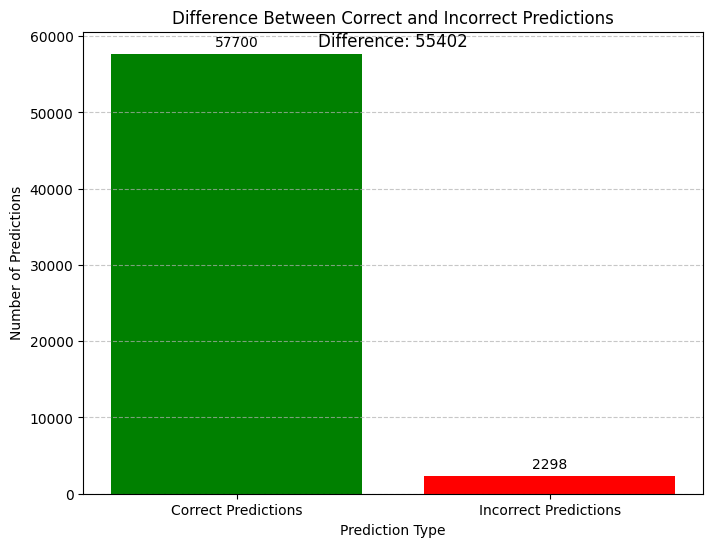

In [10]:
num_correct = evaluated[0]
num_incorrect = evaluated[1]
difference = num_correct - num_incorrect

# Plot the difference
plt.figure(figsize=(8, 6))
plt.bar(['Correct Predictions', 'Incorrect Predictions'], [num_correct, num_incorrect], color=['green', 'red'])
plt.xlabel('Prediction Type')
plt.ylabel('Number of Predictions')
plt.title('Difference Between Correct and Incorrect Predictions')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.text(0, num_correct + 1000, f'{num_correct}', ha='center')
plt.text(1, num_incorrect + 1000, f'{num_incorrect}', ha='center')
plt.text(0.5, max(num_correct, num_incorrect) + 1000, f'Difference: {difference}', ha='center', fontsize=12)
plt.show()